In [1]:
import copy
import sys
import os
import glob
sys.path.append('../..')

from model import processing
price_list = processing.import_monthly_binance_prices(['DOT', 'ETH', 'SOL', 'BTC'], start_month='May 2023', months=1)
# price_list = processing.import_binance_prices(['DOT', 'ETH', 'SOL', 'BTC'], start_date='May 1 2023', days=1)

# price_list.extend([copy.deepcopy(final_prices) for i in range(100)])

In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamicadd_asset_fee, dynamicadd_lrna_fee, cash_out_omnipool
from model.amm import omnipool_amm as oamm

from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {}
omnipool_assets = ['HDX', 'USD', 'AUSD', 'ETH', 'DOT']

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.30},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.30},
    'SOL': {'usd price': price_list[0]['SOL'], 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 10},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=0.2,
                raise_oracle_name='fee_raise',
                decay=0.00001,
                fee_max=0.001,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00005,
                fee_max=0.004,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                # skip_assets=['HDX']
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=0.000014
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPUSD': Agent(
            holdings={'USD': liquidity['USD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
    archive_all=False,
)

import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()

time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

profiler.disable()
stats = pstats.Stats(profiler)
stats.dump_stats('profile-data4')

Running with 7199 time steps
Starting simulation...
Execution time: 3.264 seconds.


In [3]:
print(type(events[0].pools))

<class 'dict'>


In [4]:
# print([events[i].agents['LPETH'].holdings for i in range(10)])
for i in range(10):
    # print(events[i].agents['LPETH'].holdings[('omnipool', 'ETH')])
    print(events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')])

print(set([events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')] for i in range(len(events))]))
l1 = [events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')] for i in range(len(events))]
l = list(set(l1))
for x in l:
    print((x,l1.count(x)))

85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
85.00363428165281
{85.00363428165281}
(85.00363428165281, 7199)


'HDX'
'USD'
'BTC'
1870.079999996735
1870.0799999967346
1870.0799999967348
1870.0799999967342
1870.079999996734
1870.0799999967335
1870.0799999967337
1870.0799999967335
1870.0799999967337
1870.0799999967335
1870.0799999967332
'ETH'
'DOT'
'SOL'


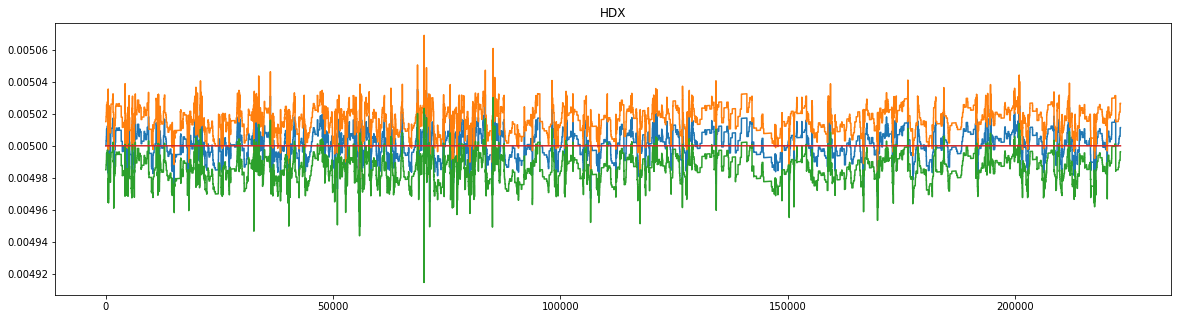

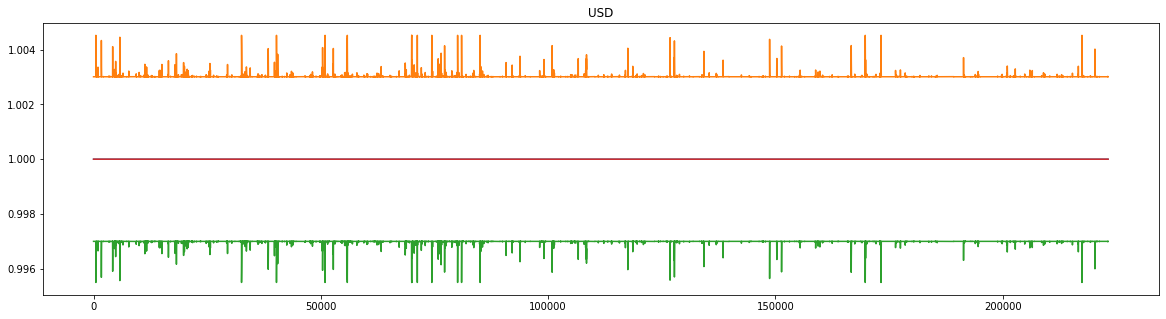

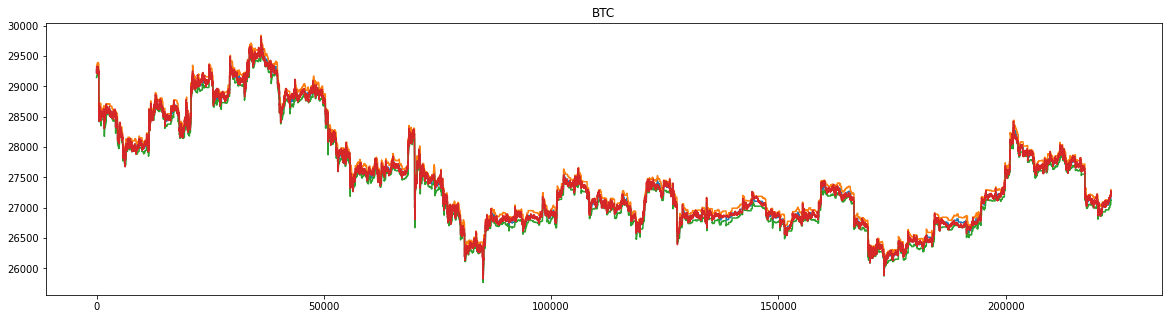

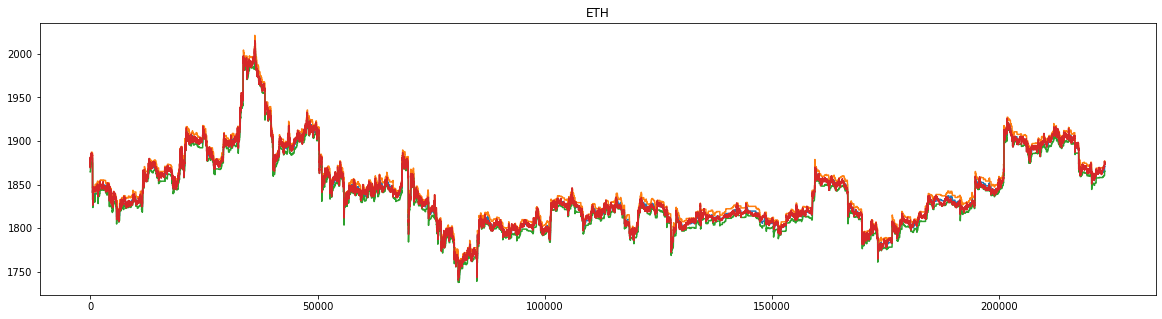

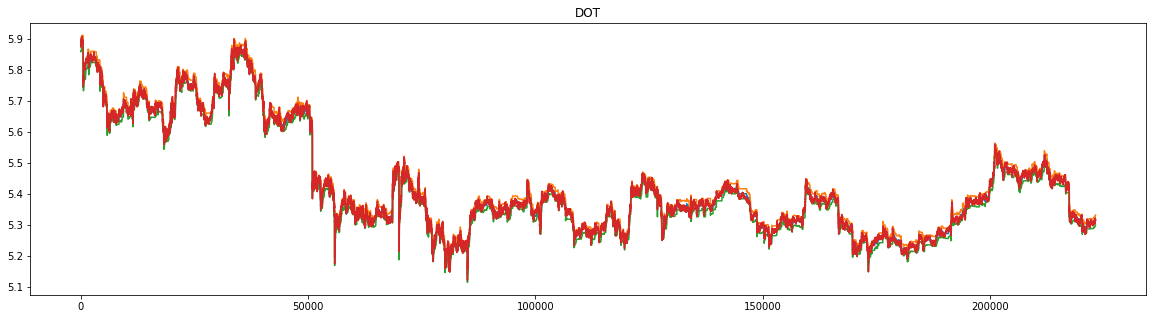

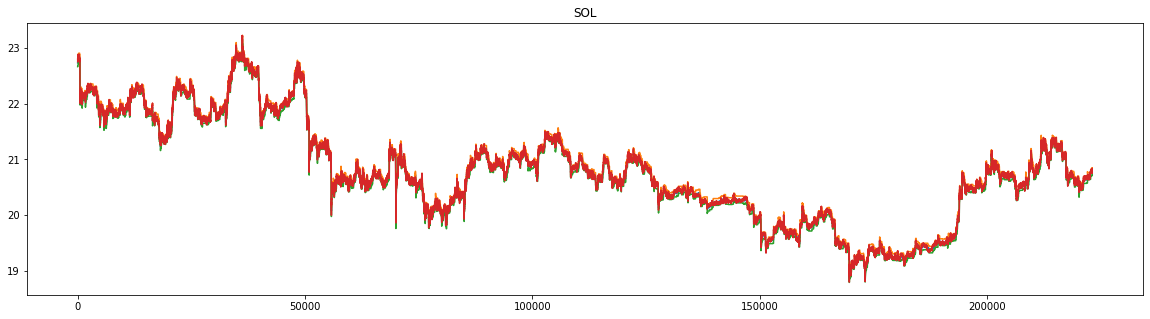

In [62]:

usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events)
USD_lrna_fees = [None]*len(events)
for i in range(len(events)):
    op = events[i].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    prices = [None]*len(events)
    last_fees = [None]*len(events)
    last_lrna_fees = [None]*len(events)
    buy_prices = [None]*len(events)
    sell_prices = [None]*len(events)
    market_prices = [None]*len(events)
    for i in range(len(events)):
        op = events[i].pools['omnipool']
        market_prices[i] = events[i].external_market[tkn]
        prices[i] = oamm.usd_price(op, tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)
    plt.title(tkn)


In [45]:
market = events[0].external_market
print(market)

{'HDX': 0.005, 'USD': 1, 'BTC': 29256.64, 'ETH': 1871.49, 'DOT': 5.879, 'SOL': 22.75}


:::FEES:::


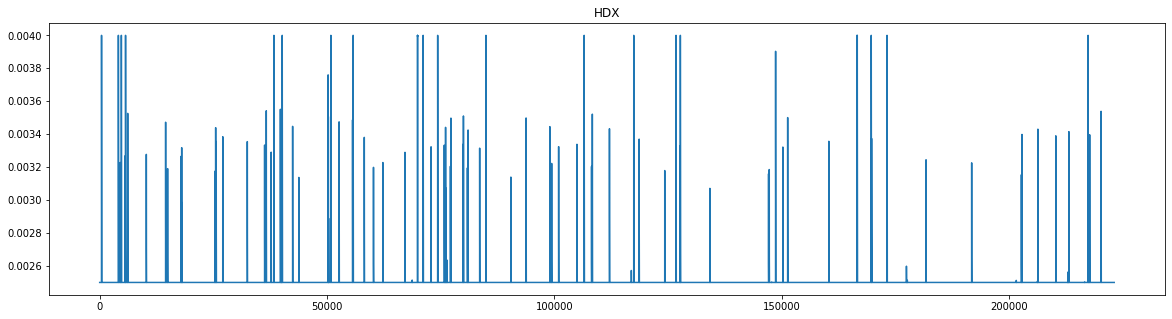

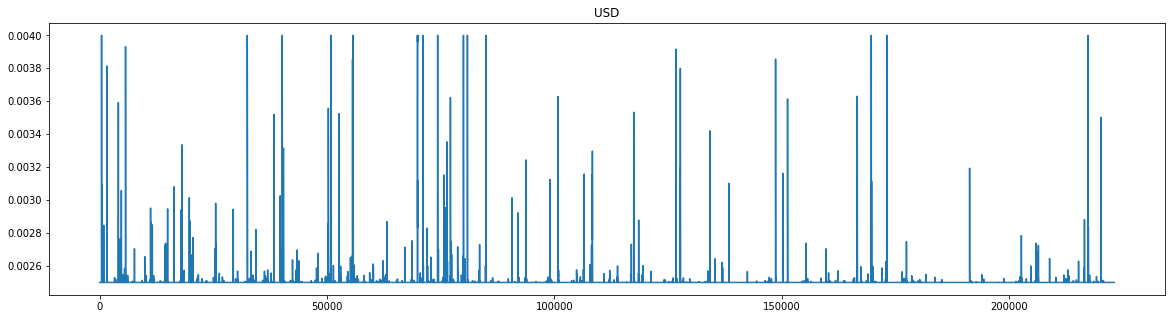

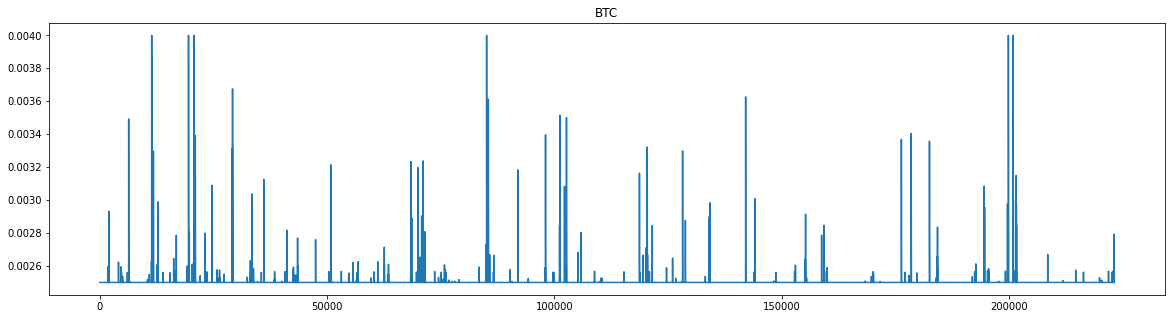

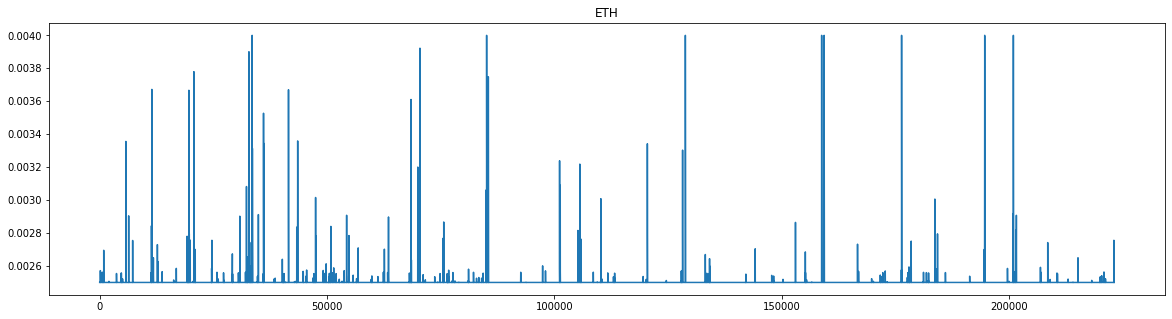

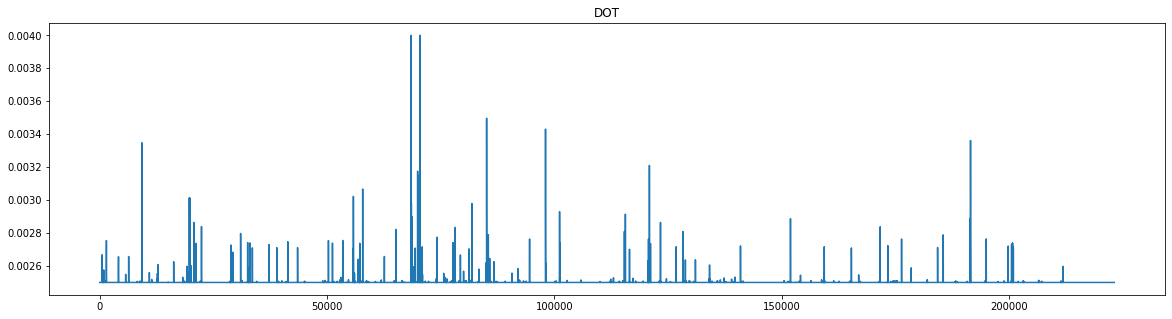

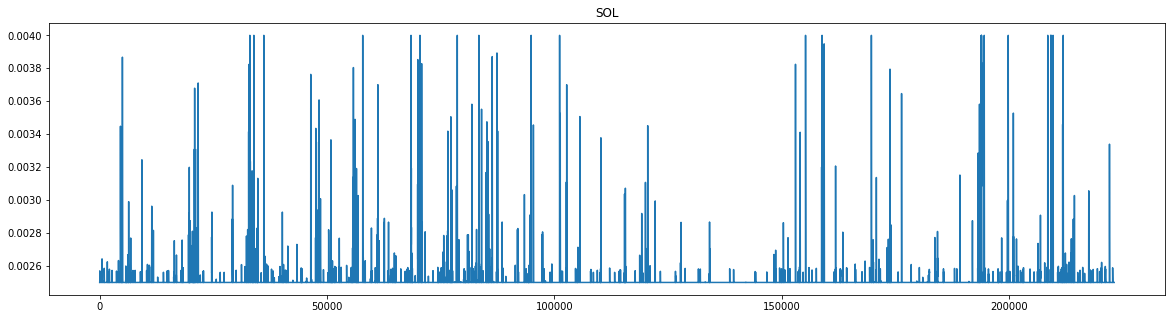

In [46]:

print(":::FEES:::")

for tkn in initial_state.pools['omnipool'].asset_list:
    last_fee = [events[i].pools['omnipool'].last_fee[tkn] for i in range(100,len(events))]
    pu.plot(last_fee)
    plt.title(tkn)

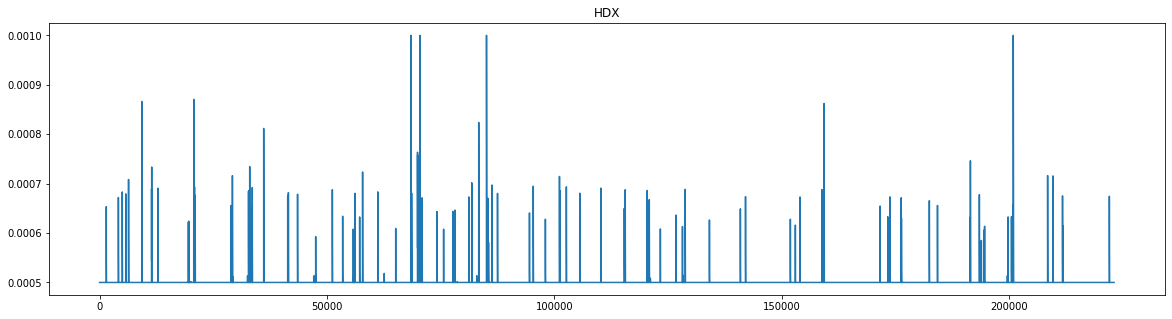

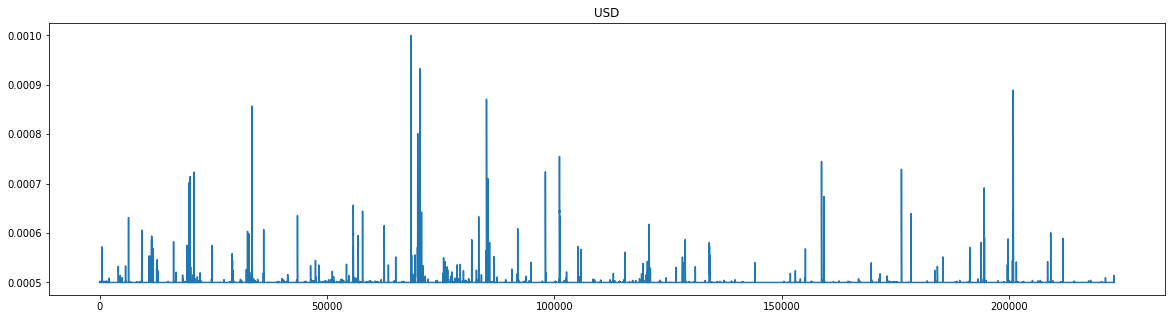

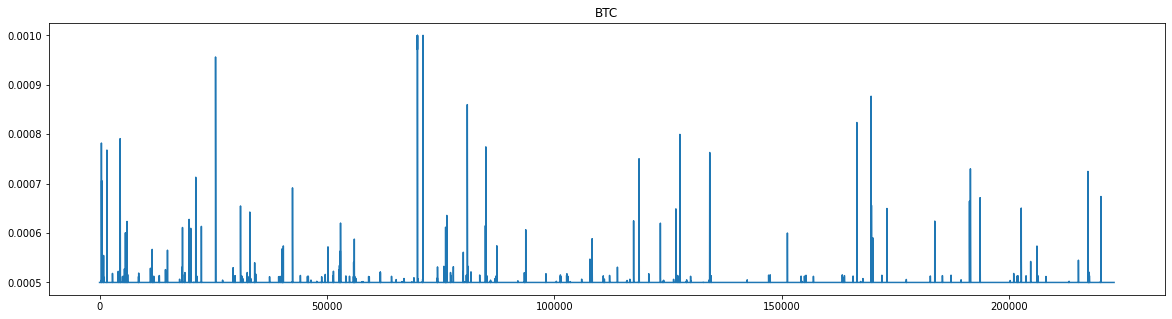

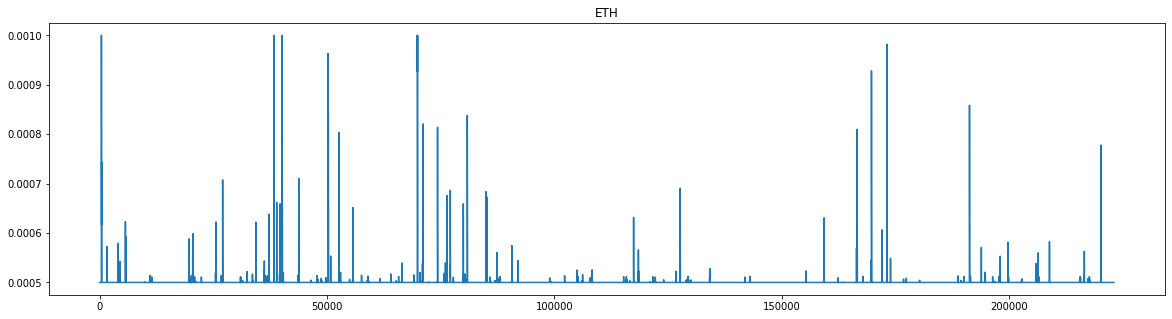

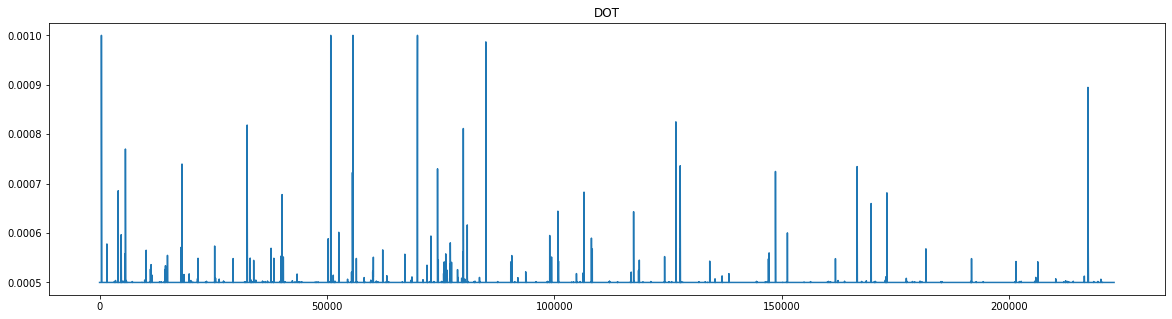

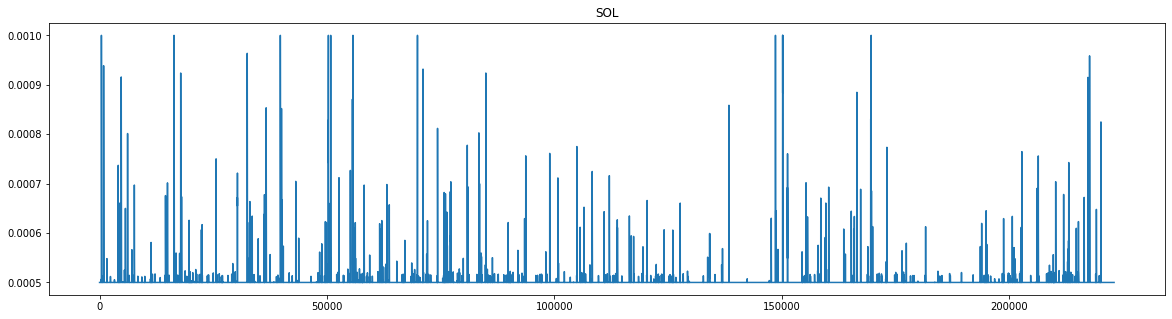

In [47]:
for tkn in initial_state.pools['omnipool'].asset_list:
    last_lrna_fee = [events[i].pools['omnipool'].last_lrna_fee[tkn] for i in range(100,len(events))]
    pu.plot(last_lrna_fee)
    plt.title(tkn)

In [48]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 49.672 seconds.


<AxesSubplot:title={'center':'  '}>

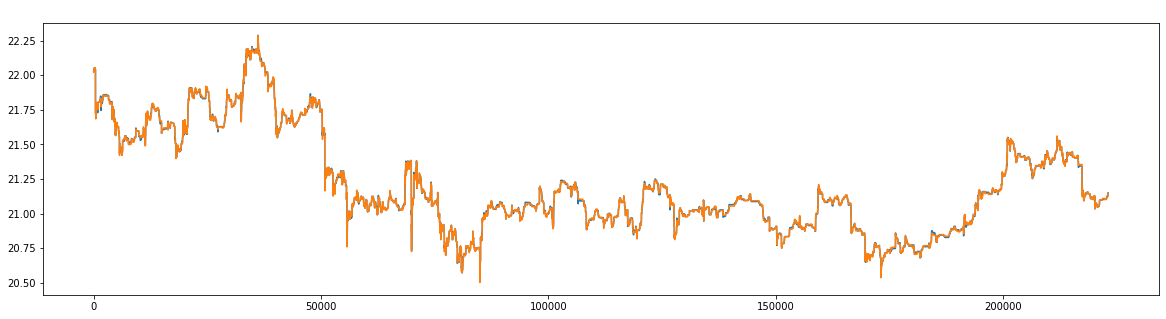

In [49]:
lrna_prices = [1/oamm.price(event.pools['omnipool'], "USD") for event in events[100:]]
lrna_prices2 = [1/oamm.price(event.pools['omnipool'], "USD") for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

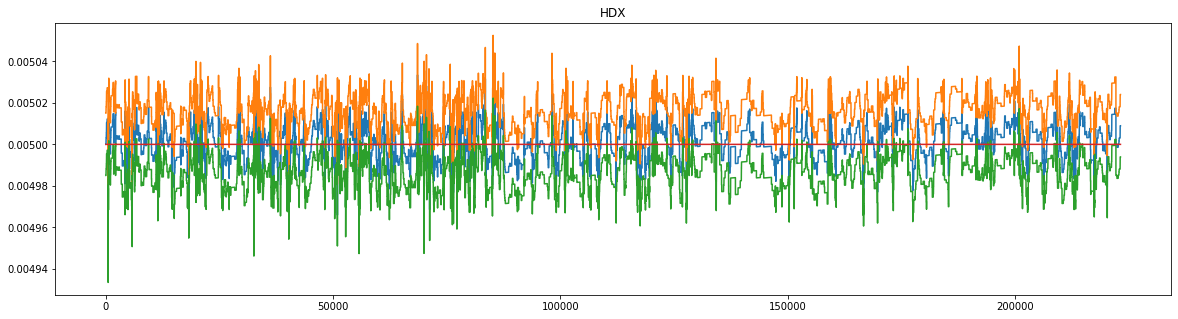

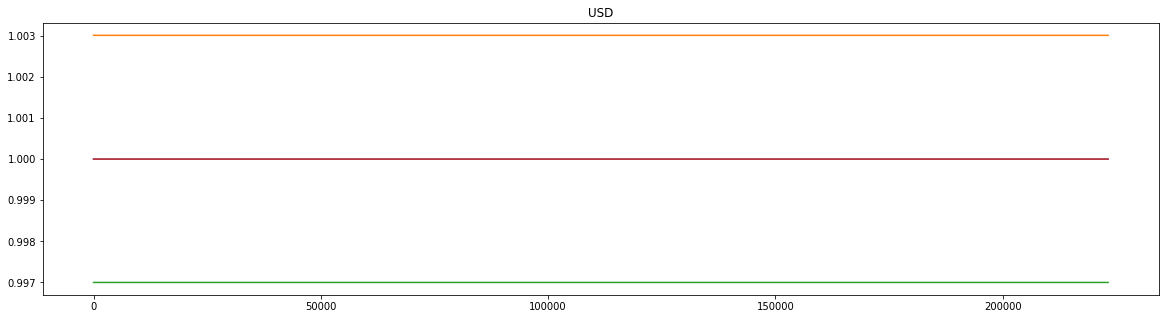

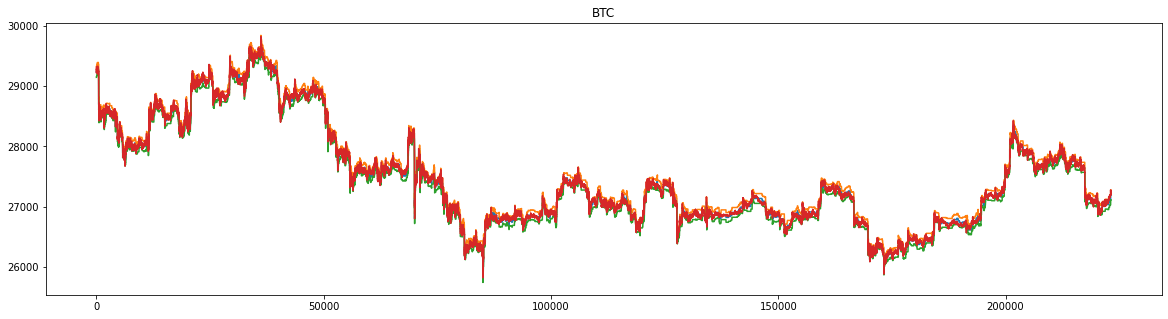

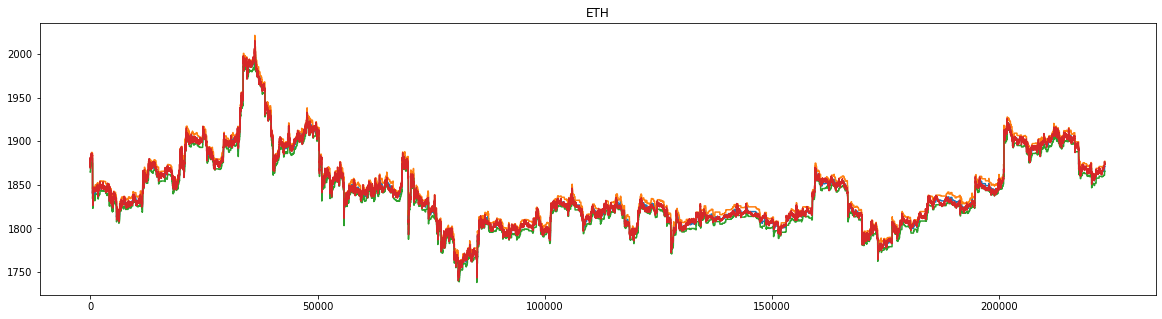

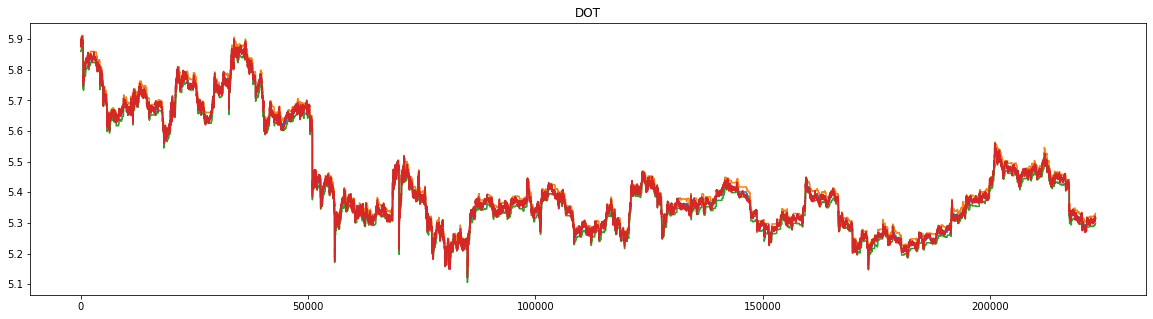

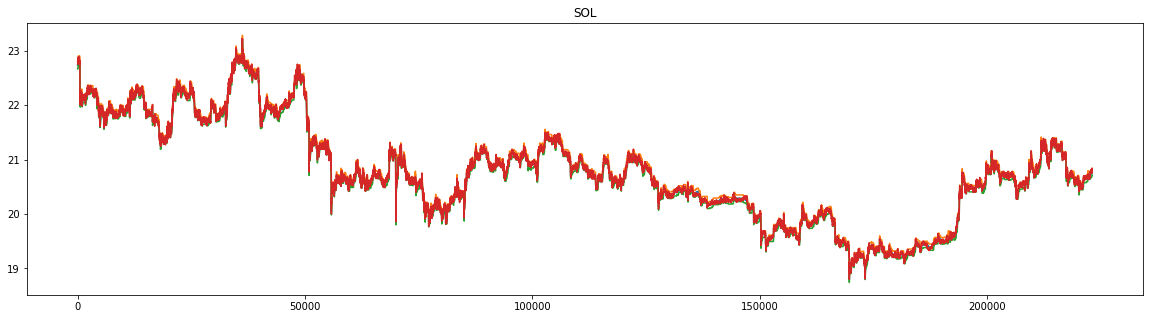

In [50]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events2)
USD_lrna_fees = [None]*len(events2)
for i in range(len(events2)):
    op = events2[i].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    prices = [None]*len(events2)
    last_fees = [None]*len(events2)
    last_lrna_fees = [None]*len(events2)
    buy_prices = [None]*len(events2)
    sell_prices = [None]*len(events2)
    market_prices = [None]*len(events2)
    for i in range(len(events2)):
        op = events2[i].pools['omnipool']
        market_prices[i] = events2[i].external_market[tkn]
        prices[i] = oamm.usd_price(op, tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pu.plot(market_prices, subplot=ax)
    plt.title(tkn)


In [51]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0000
basic_state.pools['omnipool'].asset_fee = 0.0000

events3 = run.run(basic_state, time_steps=time_steps)

Starting simulation...
Execution time: 63.377 seconds.


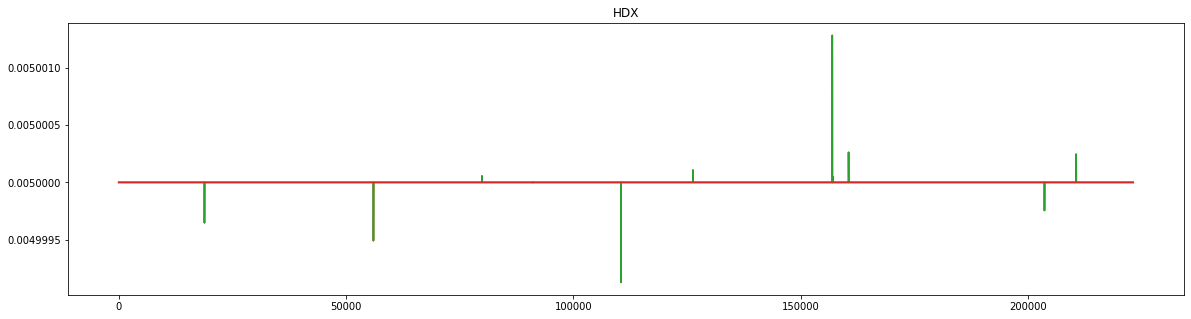

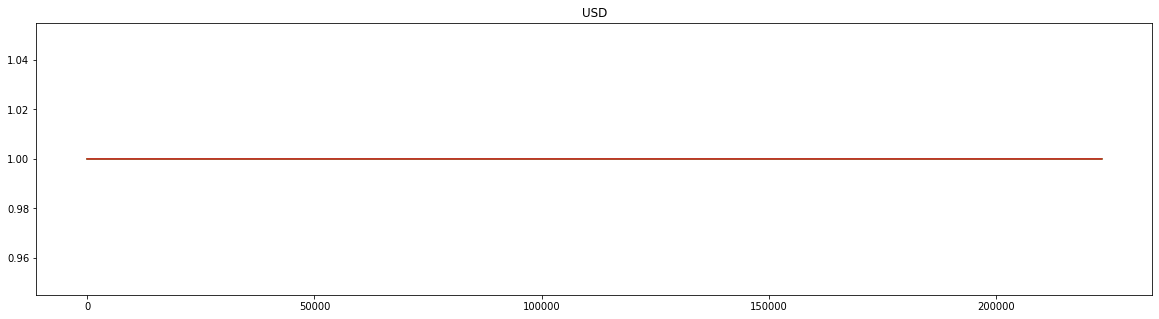

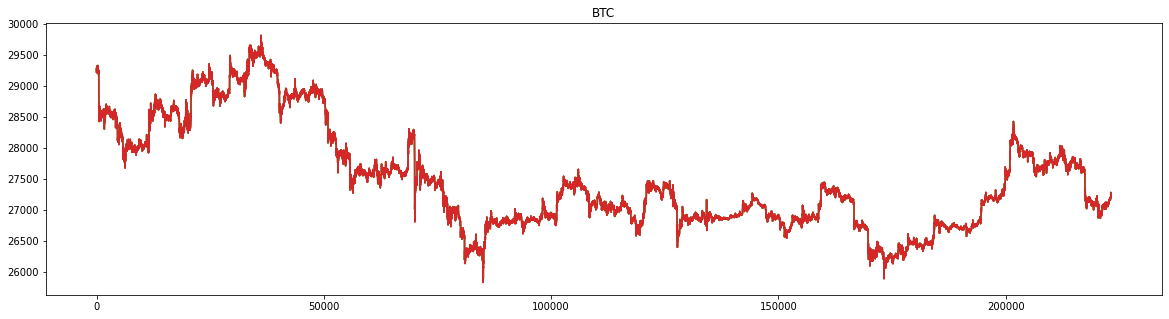

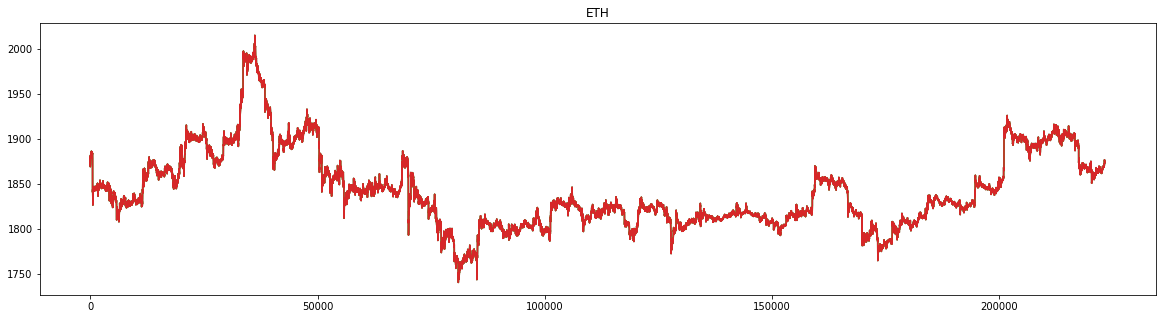

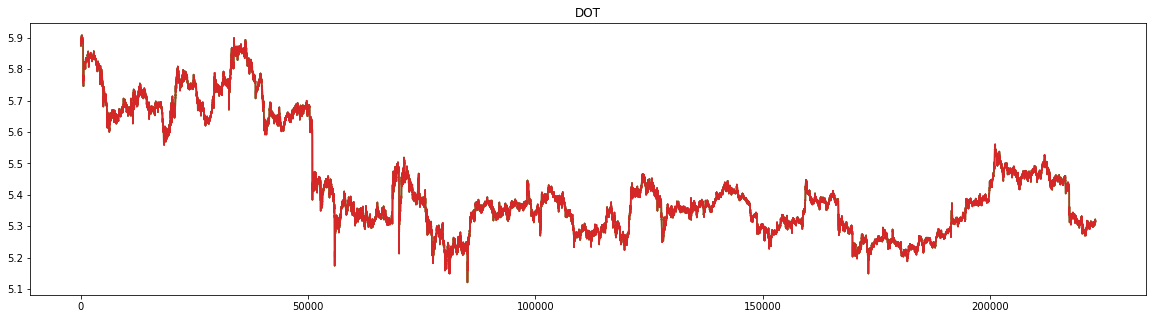

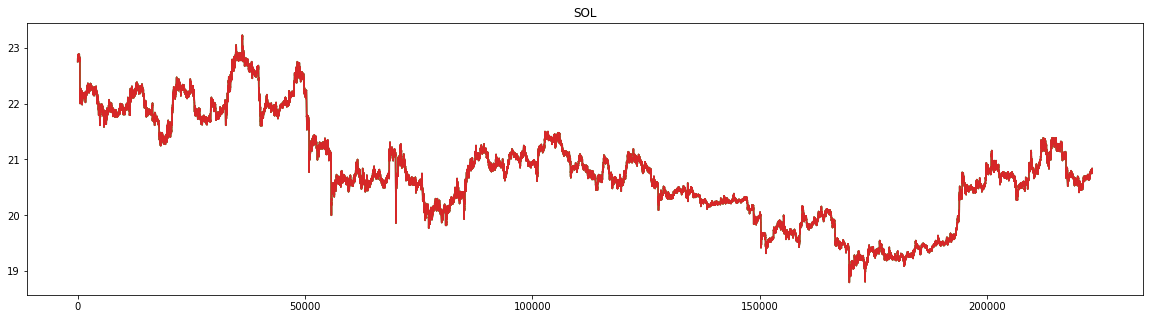

In [52]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events3)
USD_lrna_fees = [None]*len(events3)
for i in range(len(events3)):
    op = events3[i].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    prices = [None]*len(events3)
    last_fees = [None]*len(events3)
    last_lrna_fees = [None]*len(events3)
    buy_prices = [None]*len(events3)
    sell_prices = [None]*len(events3)
    market_prices = [None]*len(events3)
    for i in range(len(events3)):
        op = events3[i].pools['omnipool']
        market_prices[i] = events3[i].external_market[tkn]
        prices[i] = oamm.usd_price(op, tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pu.plot(market_prices, subplot=ax)
    plt.title(tkn)


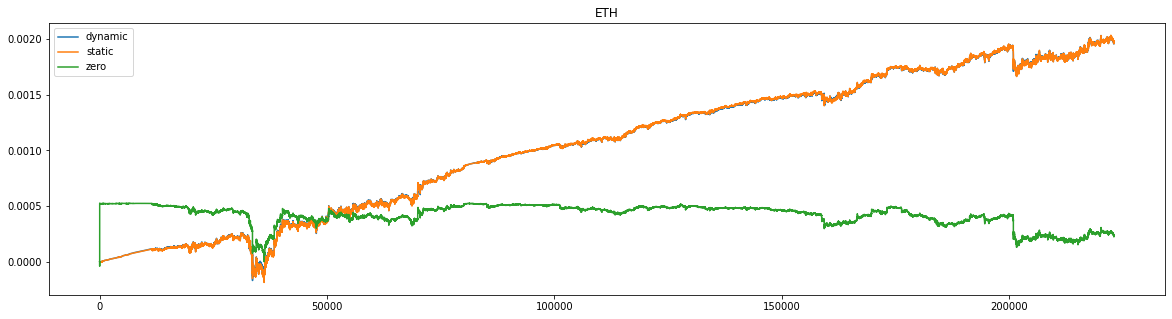

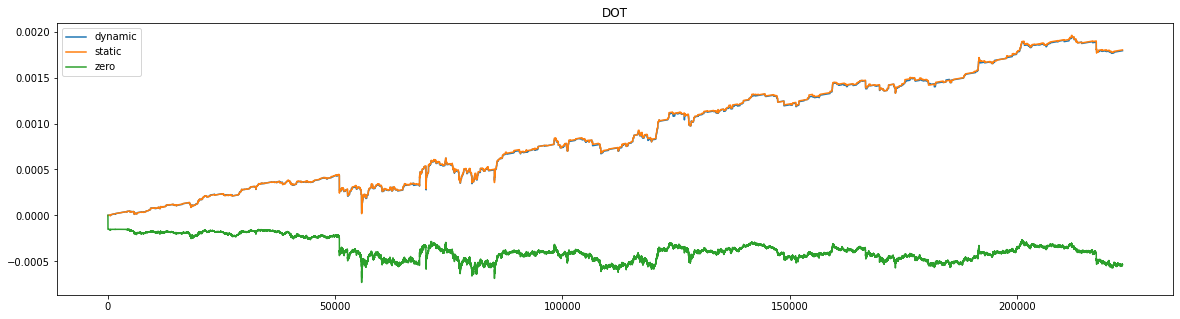

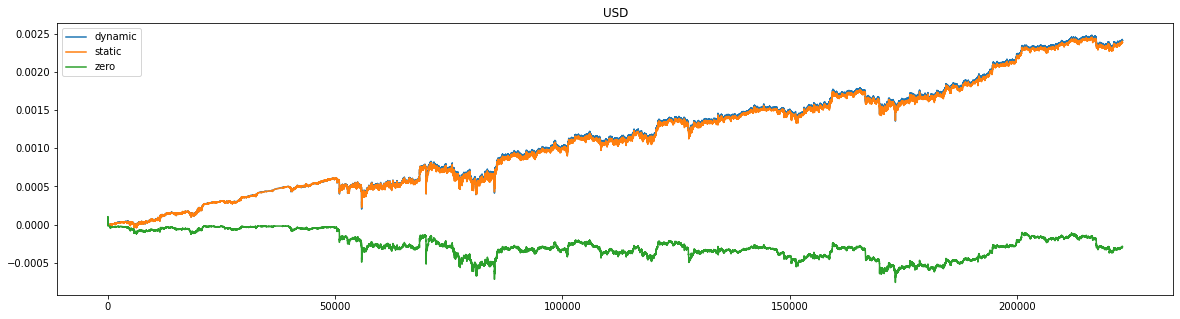

In [60]:
LP_AMT = {tkn: liquidity[tkn]/10 for tkn in ['ETH', 'DOT', 'USD']}

LP_cashout_dynamic = {}
LP_cashout_static = {}
LP_cashout_zero = {}
LP_profit_dynamic = {}
LP_profit_static = {}
LP_profit_zero = {}
LP_HOLD = {}

real_market_prices = [e.external_market for e in events]
n = len(events)

for tkn in ['ETH', 'DOT', 'USD']:
    LP_HOLD[tkn] = [LP_AMT[tkn] * p_dict[tkn] for p_dict in real_market_prices]

    LP_cashout_dynamic[tkn] = [cash_out_omnipool(e.pools['omnipool'], e.agents['LP' + tkn], e.external_market) for e in events]
    LP_cashout_static[tkn] = [cash_out_omnipool(e.pools['omnipool'], e.agents['LP' + tkn], e.external_market) for e in events2]
    LP_cashout_zero[tkn] = [cash_out_omnipool(e.pools['omnipool'], e.agents['LP' + tkn], e.external_market) for e in events3]

    LP_profit_dynamic[tkn] = [(LP_cashout_dynamic[tkn][i] - LP_HOLD[tkn][i])/LP_HOLD[tkn][i] for i in range(n)]
    LP_profit_static[tkn] = [(LP_cashout_static[tkn][i] - LP_HOLD[tkn][i])/LP_HOLD[tkn][i] for i in range(n)]
    LP_profit_zero[tkn] = [(LP_cashout_zero[tkn][i] - LP_HOLD[tkn][i])/LP_HOLD[tkn][i] for i in range(n)]



    ax = pu.plot(LP_profit_dynamic[tkn], label='dynamic')
    ax = pu.plot(LP_profit_static[tkn], subplot=ax, label='static')

    pu.plot(LP_profit_zero[tkn], subplot=ax, label='zero')
    ax.legend(loc='upper left')
    plt.title(tkn)




In [65]:
print(LP_profit_zero['ETH'][0:10])

[0.0, -4.043275698725145e-05, 0.0002720009138290372, 0.0005238027936155417, 0.0005237527289225878, 0.0005237043000697296, 0.0005230165799468491, 0.0005231632708054527, 0.0005228861042172695, 0.0005226545236803488]


In [66]:
print(LP_cashout_zero['ETH'][0:10])

[100075.39784394251, 100100.22612219462, 100044.31631316445, 99996.20353863745, 100088.75639839789, 100128.87779317588, 100346.56054484389, 100315.54431536407, 100373.29826330424, 100403.77094091508]


In [67]:
print(LP_HOLD['ETH'][0:10])

[100075.39784394251, 100104.27361396304, 100017.11156741958, 99943.85266940451, 100036.3620807666, 100076.46731690623, 100294.10506502395, 100263.09034907598, 100320.84188911704, 100351.32186858317]


In [82]:
print([events[i].pools['omnipool'].price(events[i].pools['omnipool'], 'ETH') for i in range(10)])

[85.00363428165281, 85.00363219975182, 85.00363011785504, 85.00362803596246, 85.0036259540741, 85.00362387218995, 85.00362179031, 85.00361970843426, 85.00361762656274, 85.0036155446954]


In [74]:
print([e.external_market['ETH'] for e in events[0:10]])

[1871.49, 1872.03, 1870.4, 1869.03, 1870.76, 1871.51, 1875.58, 1875.0, 1876.08, 1876.65]


In [72]:
print([1/events[i].pools['omnipool'].price(events[i].pools['omnipool'], 'USD') for i in range(10)])

[22.000000538804883, 22.000001077626827, 22.00000161644772, 22.000002155267538, 22.000002694086298, 22.00000323290399, 22.000003771720625, 22.000004310536198, 22.00000484935071, 22.00000538816416]


In [73]:
print([events[i].pools['omnipool'].price(events[i].pools['omnipool'], 'ETH') for i in range(10)])


[85.00363428165281, 85.00363219975182, 85.00363011785504, 85.00362803596246, 85.0036259540741, 85.00362387218995, 85.00362179031, 85.00361970843426, 85.00361762656274, 85.0036155446954]


In [89]:
# print([events[i].agents['LPETH'].holdings for i in range(10)])
for i in range(10):
    # print(events[i].agents['LPETH'].holdings[('omnipool', 'ETH')])
    print(events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')])

print(set([events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')] for i in range(len(events))]))
l1 = [events[i].agents['LPETH'].share_prices[('omnipool', 'ETH')] for i in range(len(events))]
l = list(set(l1))
for x in l:
    print((x,l1.count(x)))

85.00363428165281
85.00363219975182
85.00363011785504
85.00362803596246
85.00362803596246
85.00362803596246
85.00362803596246
85.00362803596246
85.00362803596246
85.00362803596246
{85.00362803596246, 85.00363219975182, 85.00363428165281, 85.00363011785504}
(85.00362803596246, 223196)
(85.00363219975182, 1)
(85.00363428165281, 1)
(85.00363011785504, 1)
